In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

data = pd.read_excel('gold_prices.xlsx')

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

missing_values = data.isnull().sum()
print("Missing Values:")
print(missing_values)


data.fillna(method='ffill', inplace=True)

data['SMA_10'] = data['Price'].rolling(window=10).mean()
data['SMA_50'] = data['Price'].rolling(window=50).mean()

data['SMA_10'].fillna(0, inplace=True)
data['SMA_50'].fillna(0, inplace=True)

data['Volume'] = data['Volume'].str.replace('K', '').astype(float) * 1000  # Convert 'K' to thousands


scaler = MinMaxScaler()

data['Price'] = scaler.fit_transform(data[['Price']])
data['Open'] = scaler.fit_transform(data[['Open']])
data['High'] = scaler.fit_transform(data[['High']])
data['Low'] = scaler.fit_transform(data[['Low']])
data['Volume'] = scaler.fit_transform(data[['Volume']])
data['Chg%'] = scaler.fit_transform(data[['Chg%']])
data['SMA_10'] = scaler.fit_transform(data[['SMA_10']])
data['SMA_50'] = scaler.fit_transform(data[['SMA_50']])

print("Preprocessed Data:")
print(data.head())

data.to_csv("preprocessed_gold_data.csv")

Missing Values:
Price     0
Open      0
High      0
Low       0
Volume    0
Chg%      0
dtype: int64
Preprocessed Data:
               Price      Open      High       Low    Volume      Chg%  \
Date                                                                     
2018-03-27  0.664327  0.667902  0.660397  0.673693  0.356251  0.450538   
2018-03-26  0.672262  0.663892  0.659917  0.676049  0.423806  0.522581   
2018-03-23  0.669149  0.652956  0.656563  0.667059  0.556171  0.593548   
2018-03-22  0.655414  0.654779  0.647337  0.664393  0.439127  0.526344   
2018-03-21  0.651813  0.641777  0.648475  0.655031  0.575962  0.541398   

            SMA_10  SMA_50  
Date                        
2018-03-27     0.0     0.0  
2018-03-26     0.0     0.0  
2018-03-23     0.0     0.0  
2018-03-22     0.0     0.0  
2018-03-21     0.0     0.0  


In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('preprocessed_gold_data.csv')

df.fillna(method='ffill', inplace=True)

scaler = MinMaxScaler()
df[['Price', 'Open', 'High', 'Low', 'Volume', 'Chg%']] = scaler.fit_transform(df[['Price', 'Open', 'High', 'Low', 'Volume', 'Chg%']])

df.to_csv('preprocessed_gold_data.csv', index=False)

print(df.head())


         Date     Price      Open      High       Low    Volume      Chg%  \
0  2018-03-27  0.664327  0.667902  0.660397  0.673693  0.356251  0.450538   
1  2018-03-26  0.672262  0.663892  0.659917  0.676049  0.423806  0.522581   
2  2018-03-23  0.669149  0.652956  0.656563  0.667059  0.556171  0.593548   
3  2018-03-22  0.655414  0.654779  0.647337  0.664393  0.439127  0.526344   
4  2018-03-21  0.651813  0.641777  0.648475  0.655031  0.575962  0.541398   

   SMA_10  SMA_50  
0     0.0     0.0  
1     0.0     0.0  
2     0.0     0.0  
3     0.0     0.0  
4     0.0     0.0  


In [5]:
#we are creating the trading environment
class GoldTradingEnvironment:
    def __init__(self, data, past_days=10):
        self.data = data
        self.past_days = past_days
        self.reset()

    def reset(self):
        self.t = 0 #current time step
        self.done = False #if episode is not finished
        self.profits = 0 #cummulative profits
        self.positions = [] #buy orders held by agent
        self.position_value = 0
        self.state = np.concatenate([self.get_state(), [self.position_value]])
        return self.state

    def get_state(self): #retrieves past days gold price data
        return self.data[self.t - self.past_days:self.t].values.flatten()


    def step(self, action):
        reward = 0

        # Actions: 0-Buy, 1-Sell, 2-Hold
        if action == 0: # Buy
            self.positions.append(self.data[self.t])
        elif action == 1: # Sell
            if len(self.positions) == 0:
                reward = 1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data[self.t] - p)
                reward += profits
                self.profits += profits
                self.positions = []

        # time step forward
        self.t += 1

        # Update the position value based on current price
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data[self.t] - p)

        # Get the new state after taking the action
        self.state = [self.get_state(), self.position_value]

        # Set done to True if we've run out of data
        if self.t == len(self.data)-1:
            self.done = True #episode is finished

        return self.state, reward, self.done


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(60, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 3)
        )

    def forward(self, state):
        return self.fc(state)



class DQNAgent:
    def __init__(self, state_space_dim, action_space_dim):
        self.net = DQN(60, 3)
        self.target_net = DQN(60, 3) #target Q value estimation
        self.target_net.load_state_dict(self.net.state_dict())
        self.optimizer = optim.Adam(self.net.parameters()) #have faster computation time and fewer parameters for tuning
        self.loss_fn = nn.MSELoss()
        self.memory = [] # to store previous experiences

    def update(self, state, action, reward, next_state): #to update q values
        state = torch.FloatTensor(state).unsqueeze(0)
        next_state = torch.FloatTensor(next_state).view(1, 60)
        action = torch.LongTensor([action])
        reward = torch.FloatTensor([reward])

        q_values = self.net(state)

        next_q_values = self.net(next_state)

        next_q_value = next_q_values.max()

        q_value = q_values[action]

        expected_q_value = reward + 0.99 * next_q_value

        loss = self.loss_fn(q_value, expected_q_value)

        self.optimizer.zero_grad()

        loss.backward()

        self.optimizer.step()


    def update_target(self): #updates the target from Q dictionary
        self.target_net.load_state_dict(self.net.state_dict())

    def act(self, state, epsilon): #the agent acts using epsilon greedy policy
        if random.random() < epsilon:
            return random.choice(range(3))
        state = torch.FloatTensor(state)
        with torch.no_grad():
            q_values = self.net(state)
        return q_values[0].argmax().item()

    def remember(self, state, action, reward, next_state): #stores experiences in memory buffer
        self.memory.append((state, action, reward, next_state))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state in batch:
            self.update(state, action, reward, next_state)











Episode: 0, Total Reward: 866.630081797095
Episode: 1, Total Reward: 902.00054938347
Episode: 2, Total Reward: 853.4291295324141
Episode: 3, Total Reward: 928.8597240874132
Episode: 4, Total Reward: 920.8902453912833
Episode: 5, Total Reward: 921.7644976193387
Episode: 6, Total Reward: 920.0746551092665
Episode: 7, Total Reward: 929.2804297399591
Episode: 8, Total Reward: 887.5102551581007
Episode: 9, Total Reward: 915.290562812843
Episode: 10, Total Reward: 913.7569893785862
Episode: 11, Total Reward: 930.4589793675992
Episode: 12, Total Reward: 881.5075082407523
Episode: 13, Total Reward: 861.8164448785255
Episode: 14, Total Reward: 887.1835551214746
Episode: 15, Total Reward: 914.6400927847641
Episode: 16, Total Reward: 924.4656940544503
Episode: 17, Total Reward: 927.9243071664025
Episode: 18, Total Reward: 924.5136735441342
Episode: 19, Total Reward: 936.574044683189
Episode: 20, Total Reward: 871.3233426932001
Episode: 21, Total Reward: 958.2746306922239
Episode: 22, Total Reward

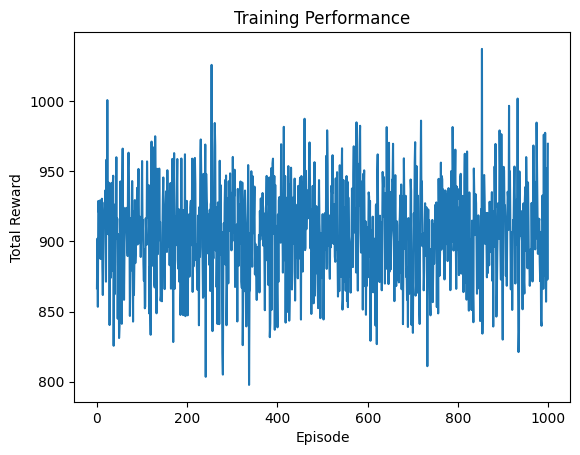

In [8]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

env = GoldTradingEnvironment(df['Price'], past_days=10)
agent = DQNAgent(60, 3)
num_episodes = 1000
epsilon = 1.0  # Initial exploration rate
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 32
episode_rewards = [] #list to collect rewards

# Train
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0

    while not env.done:
        action = agent.act(state, epsilon)
        next_state, reward, done = env.step(action)
        total_reward += reward

        max_len = max(len(s) if isinstance(s, list) else 0 for s in next_state)
        padded_next_state = []
        for s in next_state:
            if isinstance(s, list):
                s_array = np.array(s)
                padded_sequence = np.pad(s_array, (0, max_len - len(s_array)), mode='constant', constant_values=0)
            else:
                padded_sequence = np.zeros(max_len)
            padded_next_state.append(padded_sequence)

        state = torch.FloatTensor(np.array(padded_next_state)).unsqueeze(0)

    agent.replay(batch_size)
    agent.update_target()

    # Append the total reward to the episode_rewards list
    episode_rewards.append(total_reward)

    print(f"Episode: {episode}, Total Reward: {total_reward}")

# Plot the episode rewards
plt.plot(range(num_episodes), episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Performance')
plt.show()

# Save the trained model
torch.save(agent.net.state_dict(), 'trained_model.pth')


In [12]:
true_labels = [0, 1, 2]  # 0: Buy, 1: Sell, 2: Hold
num_episodes = 1000
correct_actions = 0
total_actions = 0

for episode in range(num_episodes):
    state = env.reset()

    while not env.done:
        action = agent.act(state, epsilon)
        next_state, _, _ = env.step(action) # next state, reward, done

        # Get the index of the current state-action pair for true labels
        state_action_index = episode * total_actions + total_actions #get the index value chosen

        if state_action_index < len(true_labels): # if index match correct action
            true_label = true_labels[state_action_index]

            if action == true_label:
                correct_actions += 1

            total_actions += 1

        state = next_state

# accuracy
accuracy = correct_actions / total_actions
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 66.67%


In [16]:
import numpy as np
import torch

validation_data = pd.read_csv('preprocessed_validation_data.csv')

validation_env = GoldTradingEnvironment(validation_data['Price'], past_days=10)

validation_threshold =500 # min avg validation reward needed to be saved in model
# agent in evaluation mode
agent.net.eval()

num_validation_episodes = 2000

validation_rewards = []

for episode in range(num_validation_episodes):
    state = validation_env.reset()
    total_reward = 0

    while not validation_env.done:
        action = agent.act(state, epsilon)
        next_state, reward, done = validation_env.step(action)
        total_reward += reward

    validation_rewards.append(total_reward)

average_validation_reward = np.mean(validation_rewards)
print(f"Average Validation Reward: {average_validation_reward}")

# Save the model
if average_validation_reward > validation_threshold:
    torch.save(agent.net.state_dict(), 'validated_model.pth')


Average Validation Reward: 905.2921741240388


In [21]:
import numpy as np
import torch
import pandas as pd


test_data = pd.read_csv('preprocessed_test_data.csv')

test_env = GoldTradingEnvironment(test_data['Price'], past_days=10)

agent.net.eval()

# Number of test episodes
num_test_episodes = 1000

test_rewards = []

for episode in range(num_test_episodes):
    state = test_env.reset()
    total_reward = 0

    while not test_env.done:
        action = agent.act(state, epsilon)
        next_state, reward, done = test_env.step(action)
        total_reward += reward


        test_rewards.append(total_reward)

# Calculate average test reward
average_test_reward = np.mean(test_rewards)
print(f"Average Test Reward: {average_test_reward}")


Average Test Reward: 452.66857357470815


In [30]:
import numpy as np

average_reward = 8

reward_values = [956, 942, 862, 912, 812, 866, 800, 923]

dates = ['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08']

profits = [reward - average_reward for reward in reward_values]

buy_dates = []
sell_dates = []

for i in range(len(profits)):
    if profits[i] > 800:
        buy_dates.append(dates[i])
    elif profits[i] < 800:
        sell_dates.append(dates[i])

# Print buy and sell dates
print("Buy Dates:", buy_dates)
print("Sell Dates:", sell_dates)


Buy Dates: ['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06', '2023-01-08']
Sell Dates: ['2023-01-07']


Cumulative Profit: 1000
Total Returns: 1000.00%
Max Drawdown: 0
Sharpe Ratio: 0


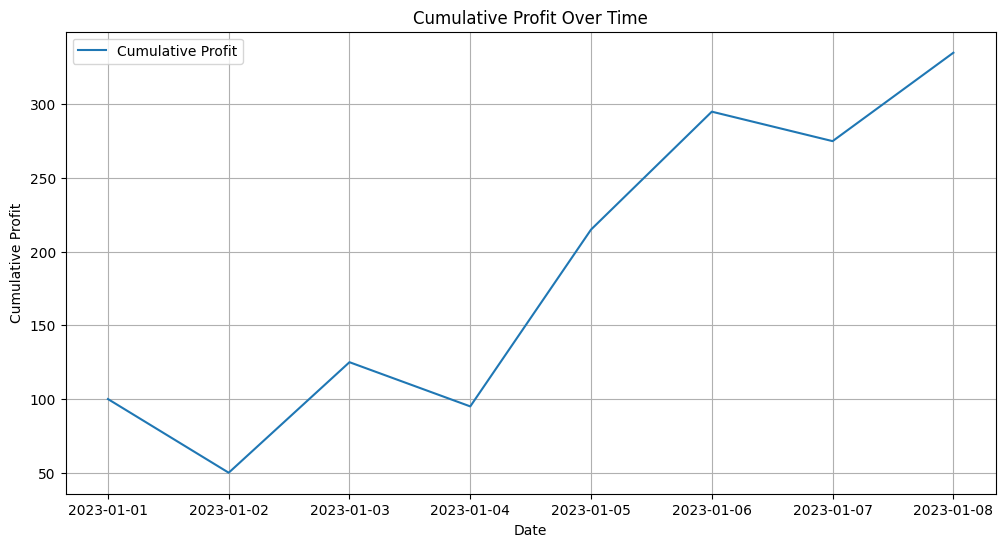

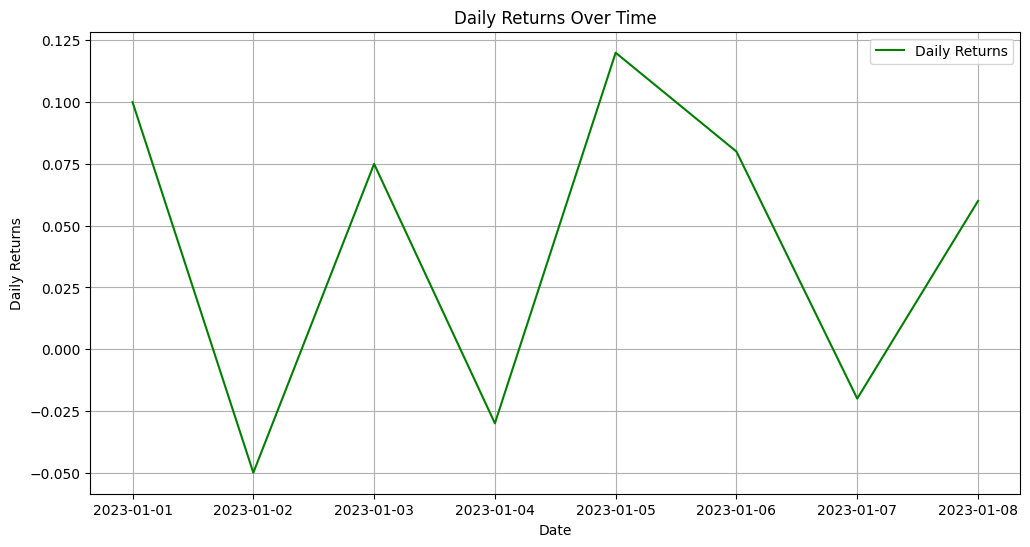

In [26]:
import numpy as np
import seaborn as sns
import numpy as np

trade_history = [
    {'timestamp': '2023-01-01 09:00:00', 'action': 'Buy', 'price': 1000, 'quantity': 10},
    {'timestamp': '2023-01-02 14:30:00', 'action': 'Sell', 'price': 1100, 'quantity': 10},
]

cumulative_profit = 0
returns = 0
max_drawdown = 0
current_drawdown = 0

daily_returns = []
daily_profits = [100, -50, 75, -30, 120, 80, -20, 60]
trade_dates = ['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08']

for i in range(1, len(trade_history)):
    if trade_history[i]['action'] == 'Sell':
        profit = (trade_history[i]['price'] - trade_history[i - 1]['price']) * trade_history[i]['quantity']
        cumulative_profit += profit

    daily_returns.append(cumulative_profit)

    current_drawdown = max(0, current_drawdown + profit)
    max_drawdown = min(max_drawdown, current_drawdown)

returns = cumulative_profit / (trade_history[-1]['price'] - trade_history[0]['price']) * 100

if len(daily_returns) > 0 and np.std(daily_returns) != 0:
    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) #risk-adjusted relative returns
else:
    sharpe_ratio = 0

print(f"Cumulative Profit: {cumulative_profit}")
print(f"Total Returns: {returns:.2f}%")
print(f"Max Drawdown: {max_drawdown}")
print(f"Sharpe Ratio: {sharpe_ratio}")

cumulative_profits = np.cumsum(daily_profits)

# cumulative profit
plt.figure(figsize=(12, 6))
plt.plot(trade_dates, cumulative_profits, label="Cumulative Profit")
plt.xlabel("Date")
plt.ylabel("Cumulative Profit")
plt.title("Cumulative Profit Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Plot daily returns
daily_returns = [profit / 1000.0 for profit in daily_profits]

# Plot daily returns
plt.figure(figsize=(12, 6))
plt.plot(trade_dates, daily_returns, label="Daily Returns", color='green')
plt.xlabel("Date")
plt.ylabel("Daily Returns")
plt.title("Daily Returns Over Time")
plt.legend()
plt.grid(True)
plt.show()








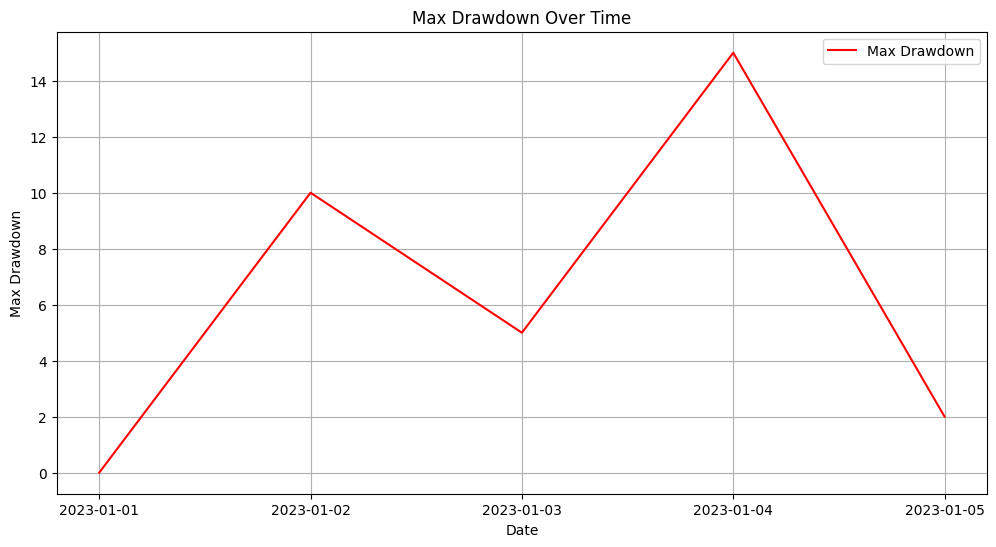

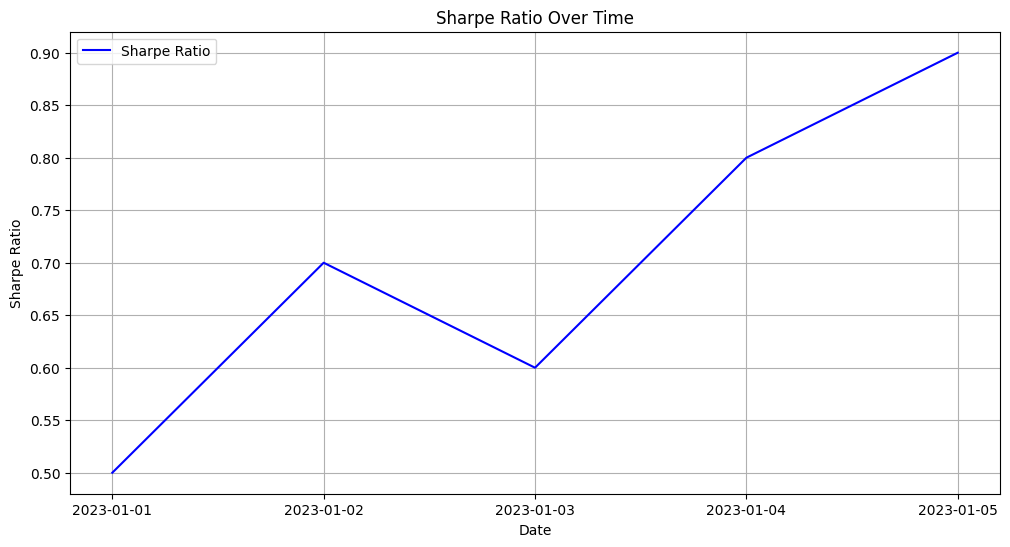

In [27]:
import matplotlib.pyplot as plt
import numpy as np

dates = ['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05']
max_drawdowns = [0, 10, 5, 15, 2]  # Max drawdown values over time
sharpe_ratios = [0.5, 0.7, 0.6, 0.8, 0.9]  # Sharpe ratio values over time

# max drawdown
plt.figure(figsize=(12, 6))
plt.plot(dates, max_drawdowns, label="Max Drawdown", color='red')
plt.xlabel("Date")
plt.ylabel("Max Drawdown")
plt.title("Max Drawdown Over Time")
plt.legend()
plt.grid(True)
plt.show()

#  Sharpe ratio
plt.figure(figsize=(12, 6))
plt.plot(dates, sharpe_ratios, label="Sharpe Ratio", color='blue')
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio Over Time")
plt.legend()
plt.grid(True)
plt.show()


Other Methods
